In [1]:
import scipy as sp
import numpy as np
import pandas as pd
import timeit
import re
import json
import pickle
import fastparquet
import os
os.chdir('/mnt/t48/bighomes-active/sfeng/patentdiffusion/')
seed = 3
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
import datetime
import string

- Code taken from: https://sfengc7.stern.nyu.edu:8888/notebooks/patentdiffusion/201804KnowledgeSpilloversRep/3b-RegCoefficients-0508.ipynb
- Also: https://sfengc7.stern.nyu.edu:8888/notebooks/patentdiffusion/201808Results/Reg1016/4b-RegCoefficients-1016.ipynb

## Abstracts Estimates Graphs

In [2]:
pathdir = "DataStore/2018-10/Reg1016/"
reg_f = "reg_model_1016.pkl"

regs = pickle.load(open(pathdir+reg_f, "rb"))

# Model names to equations
regs["model_names_eqn"] = dict(zip(regs["model_names"].tolist(), regs["model_names"].index.tolist()))

In [3]:
# JTH Rep
jr = pd.read_csv("DataStore/2018-07-P3/JTHReg0727/JTH_res_out_0726.csv",index_col=0)
jr.loc[jr["index"] == "$I(MSA \, Match)$", "index"] = "C(inv_msa_match)[T.True]"

# FE results (0930 - uses full dataset) and Sim results (1003 - uses only those with sim pc, sim pc msa values)
rr = pd.read_csv("DataStore/2018-10/Reg1016/reg_pairs_out_HC1_1016.csv",index_col=0)

# Use reg_model_1002 to assign model numbers
rr["Model Num"] = rr["Model"].map(regs["model_names_eqn"])

# Get rid of models without a number (squared ones excluded from analysis)
print(len(rr))
rr = rr.loc[rr["Model Num"].notnull()]
print(len(rr))
rr["samp"] = rr["samp"].apply(eval)
rr = pd.concat([jr,rr],axis=0)
# Reset index
rr = rr.reset_index(drop=True)
# Integer model number
rr["Model Num"] = rr["Model Num"].astype(int)
# Equation id
rr["id"] = ["({0}, {1}, {2})".format(i,j,k) for i,j,k in zip(rr["samp"], rr["LKS"], rr["Model"])]
rr["id"] = rr["id"].astype(str)

# Add S.E.
# S.E. index
se_ind = rr.loc[rr["index"].isnull()].index.tolist()

for ind in se_ind:
    rr.loc[ind, "index"] = "SE {0}".format(rr.loc[ind-1, "index"])

4512
4512


/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


Define function for returning plots based on regression models

In [4]:
# Regression models
rm = [
    # JTH norm percentage match PC FE
    "(JTH Rep, norm_perc_match_10, N Perc Match Targ MSA, PC FE)",
    # PC: Incl all FE
    "(('docvecs', 'primclass'), norm_sim_docvecs, N Exam FE-Year FE)",
    # NAICS: Include Sim PC
    "(('docvecs', 'naics_name'), norm_sim_docvecs, N PC M-Sim PC MSA)",   
]
rmn = ["Local. in Citations", "Local. in Sim - Primclass", "Local. in Sim - NAICS"]
rm_d = dict(zip(rm, rmn))

In [5]:
%matplotlib inline
sns.set(font_scale=2)
sns.set_style("ticks")
plt.rcParams["font.family"] = "Liberation Sans"
plt.rcParams.update({'font.size': 14})
plt.style.use('seaborn-muted')
# plt.rcParams.update({'figure.autolayout': True})

def repl_other_match(x):
    for other_match in ["common_pat_inv", "primclass_match", "examiner_match",\
                        "lawyer_match", "common_cited_match", "common_npc_match"]:
        x = x.replace(other_match, "inv_msa_match")
    return x

def convert_num(line):
    translator = str.maketrans('', '', '()*')
    try:
        c = np.float(line.translate(translator))
    except Exception:
        c = line
    return c

def get_est_data(rmd, local=True):
    if local is True:
        # Localization estimates
        rc = rr.loc[rr["id"].isin(rmd.keys()) & rr["index"].isin(["C(inv_msa_match)[T.True]", "SE C(inv_msa_match)[T.True]"])]
        rc = rc.applymap(convert_num)

        # New id
        rc["id"] = rc["id"].map(rmd)
        
    else:
        rc = rr.loc[rr["id"].isin(rmd.keys())]

        # Replace index
        rc["index"] = rc["index"].apply(repl_other_match)

        # Only use Estimate and S.E.
        rc = rc.loc[rc["index"].isin(["C(inv_msa_match)[T.True]", "SE C(inv_msa_match)[T.True]"])]

        rc = rc.applymap(convert_num)
        # New id
        rc["id"] = rc["id"].map(rmd)
    
    # Reshape long
    rcl = pd.DataFrame()
    for ind in rc.loc[(rc["index"] == "C(inv_msa_match)[T.True]")].index:
        r2 = pd.DataFrame()
        r2["Year Group"] = ["1975-85", "1985-95", "1995-05", "2005-15"]
        r2["Local Est"] = rc.loc[ind, ["1975-85", "1985-95", "1995-05", "2005-15"]].tolist()
        se = rc.loc[ind+1, ["1975-85", "1985-95", "1995-05", "2005-15"]].values
        r2["Err Bar"] = se*1.96
        r2["id"] = rc.loc[ind, "id"]
        rcl = rcl.append(r2, ignore_index=True)
    return rcl
    

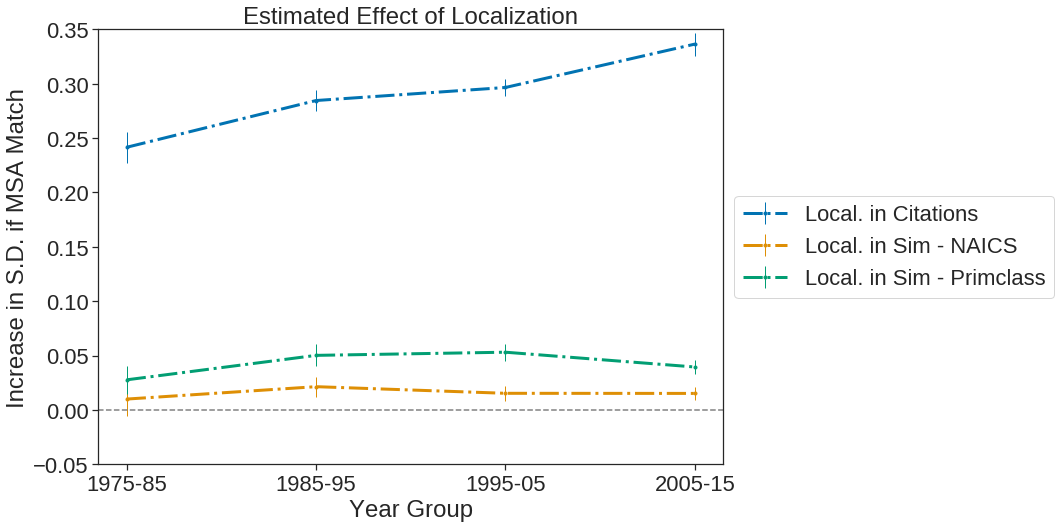

In [107]:
rcl = get_est_data(rm_d, local=True)
d2 = rcl.groupby("id")
spal = sns.color_palette("colorblind", 10).as_hex()
# spal = sns.choose_colorbrewer_palette("qualitative")
# spal = sns.color_palette("Paired", 4).as_hex()
cpal = dict(zip(d2.groups.keys(),spal))
key_order = list(d2.groups.keys())
x_col = "Year Group"
y_col = "Local Est"
y_err="Err Bar"
y_min = -0.05
y_max = 0.35

fig, ax = plt.subplots(figsize=(14,8))
for n in key_order:
    ax.errorbar(x = x_col, y = y_col, yerr = y_err, errorevery=1, fmt=".-", ls="-.",
                elinewidth = 1, 
                    linewidth = 3, color = cpal[n], label = n, data = d2.get_group(n).copy())

# Horizontal line
ax.axhline(y=0, color='grey', linestyle='--')

ax.legend()
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("Estimated Effect of Localization")

ax.set_xlabel(x_col)
ax.set_ylabel("Increase in S.D. if MSA Match")
ax.set_ylim(y_min, y_max)
plt.savefig("DataStore/2018-10/ResultsGraphs/main_local_est.png")
plt.show()

### NAICS Sample - Other Match Estimates

In [136]:
# Other match
rm2 = [
    # docvecs N PC FE
    "(('docvecs', 'naics_name'), norm_sim_docvecs, N PC FE-Year FE)",

    "(('docvecs', 'naics_name'), norm_sim_docvecs, N PC M)",
    
    "(('docvecs', 'naics_name'), norm_sim_docvecs, N Inv M)",
    
    "(('docvecs', 'naics_name'), norm_sim_docvecs, N CC M)"
]

rm2n = ["MSA Match", "PC Match", "Inv Match", "Common Cited Match"]
rm2 = dict(zip(rm2, rm2n))

/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


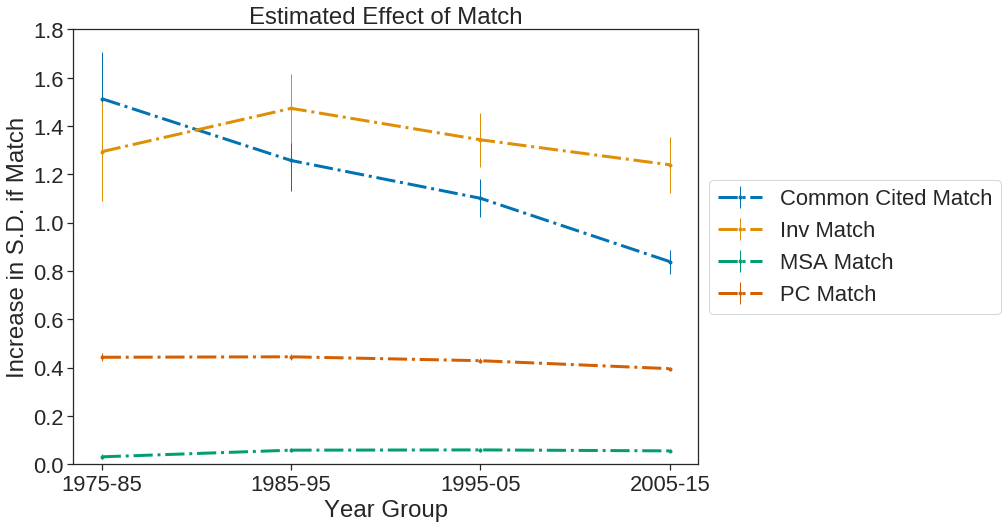

In [189]:
rcl = get_est_data(rm2, local=False)
d2 = rcl.groupby("id")
spal = sns.color_palette("colorblind", 10).as_hex()
cpal = dict(zip(d2.groups.keys(),spal))
key_order = list(d2.groups.keys())
x_col = "Year Group"
y_col = "Local Est"
y_err="Err Bar"
y_min = 0
y_max = 1.8

fig, ax = plt.subplots(figsize=(14,8))
for n in key_order:
    ax.errorbar(x = x_col, y = y_col, yerr = y_err, errorevery=1, fmt=".-", ls="-.",
                elinewidth = 1, 
                    linewidth = 3, color = cpal[n], label = n, data = d2.get_group(n).copy())

# Horizontal line
# ax.axhline(y=0, color='grey', linestyle='--')

ax.legend()
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("Estimated Effect of Match")

ax.set_xlabel(x_col)
ax.set_ylabel("Increase in S.D. if Match")
ax.set_ylim(y_min, y_max)
fig.savefig("DataStore/2018-10/ResultsGraphs/naics_other_est.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show()

## 2. Lawyer and examiner match


Accounting for similarity in primary class reduces effect of examiner a lot - examiners must get patents from similar tech areas; more of an effect than for lawyers

In [6]:
# Reshape long
def get_id_label(col, model_id):
    if (col == "lawyer_match") & ("Sim PC" in model_id):
        l = "Lawyer Match - Tech Prox"
    elif (col == "lawyer_match") & ~("Sim PC" in model_id):
        l = "Lawyer Match"
    elif (col == "examiner_match") & ("Sim PC" in model_id):
        l = "Examiner Match - Tech Prox"
    else:
        l = "Examiner Match"
    return l

### Function to get plots

In [7]:
def get_LE_plots(rmn, measure, graph_name, ymax):
    m_vars = ["C(examiner_match)[T.True]", "C(lawyer_match)[T.True]"]
    m_vars = m_vars+["SE "+c for c in m_vars]
    rc = rr.loc[rr["id"].isin(rmn)]
    # rc2 = rc.loc[rc["index"].apply(lambda x: "[T.True]" in x)]
    rc2 = rc.loc[rc["index"].isin(m_vars)]
    rc2 = rc2[["index", "1975-85", "1985-95", "1995-05", "2005-15", ]]
    rc2["index"] = rc2["index"].apply(lambda x: "S.E." if "SE "in x else x)

    # Convert to numeric
    rc = rc.applymap(convert_num)

    rcl = pd.DataFrame()
    for col in ["lawyer_match", "examiner_match"]:
        for ind in rc2.loc[(rc2["index"] == "C({0})[T.True]".format(col))].index:

            r2 = pd.DataFrame()
            r2["Year Group"] = ["1975-85", "1985-95", "1995-05", "2005-15"]
            r2["Local Est"] = rc.loc[ind, ["1975-85", "1985-95", "1995-05", "2005-15"]].tolist()
            se = rc.loc[ind+1, ["1975-85", "1985-95", "1995-05", "2005-15"]].values
            r2["Err Bar"] = se*1.96
            r2["id"] = get_id_label(col, rc.loc[ind, "id"])
            r2["var"] = col
            rcl = rcl.append(r2, ignore_index=True)

    d2 = rcl.groupby("id")
    spal = sns.color_palette("colorblind", 10).as_hex()
    cpal = dict(zip(d2.groups.keys(),spal))
    key_order = list(d2.groups.keys())
    x_col = "Year Group"
    y_col = "Local Est"
    y_err="Err Bar"
    y_min = 0
    y_max = ymax

    fig, ax = plt.subplots(figsize=(10,8))
    for n in key_order:
        ax.errorbar(x = x_col, y = y_col, yerr = y_err, errorevery=1, fmt=".-", ls="-.",
                    elinewidth = 1, 
                        linewidth = 3, color = cpal[n], label = n, data = d2.get_group(n).copy())

    # Horizontal line
    # ax.axhline(y=0, color='grey', linestyle='--')

    ax.legend()

    lgd = ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4))
    ax.set_title("{0} - Estimated Effect of Match".format(measure))

    ax.set_xlabel(x_col)
    ax.set_ylabel("Increase in S.D. if Match")
    ax.set_ylim(y_min, y_max)
    fig.savefig("DataStore/2018-10/ResultsGraphs/{0}.png".format(graph_name), bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

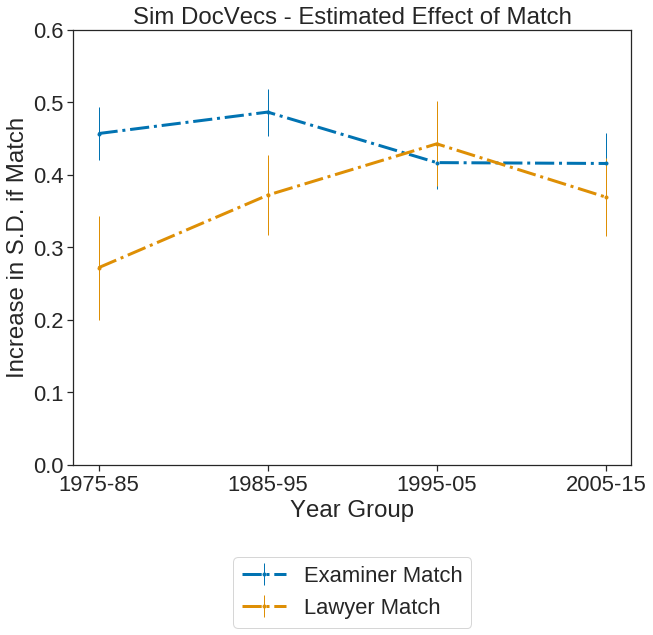

In [184]:
sdv1 = [

    "(('docvecs', 'naics_name'), norm_sim_docvecs, N Lawyer M)",

    "(('docvecs', 'naics_name'), norm_sim_docvecs, N Examiner M)",

#     "(('docvecs', 'naics_name'), norm_sim_docvecs, N PC M-Sim PC)"
]

get_LE_plots(sdv1, "Sim DocVecs", "DV_LE", 0.6)

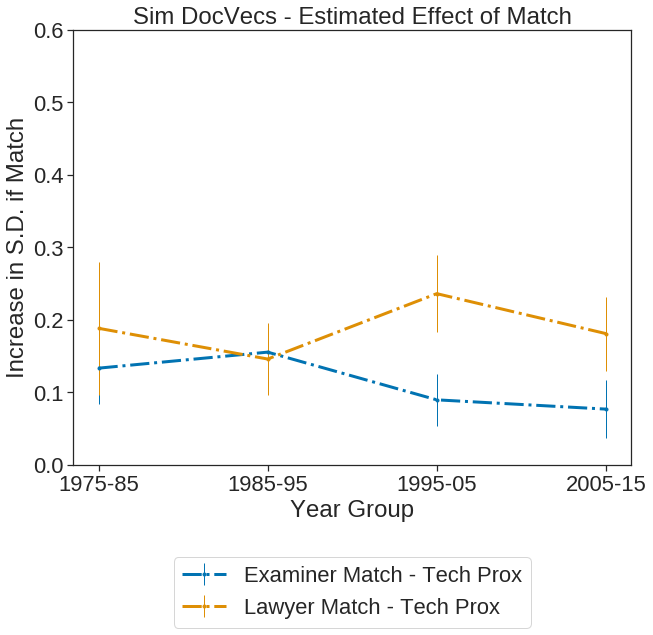

In [185]:
sdv2 = [

#     "(('docvecs', 'naics_name'), norm_sim_docvecs, N Lawyer M)",

#     "(('docvecs', 'naics_name'), norm_sim_docvecs, N Examiner M)",

    "(('docvecs', 'naics_name'), norm_sim_docvecs, N PC M-Sim PC)"
]

get_LE_plots(sdv2, "Sim DocVecs", "DV_LE_tp", 0.6)

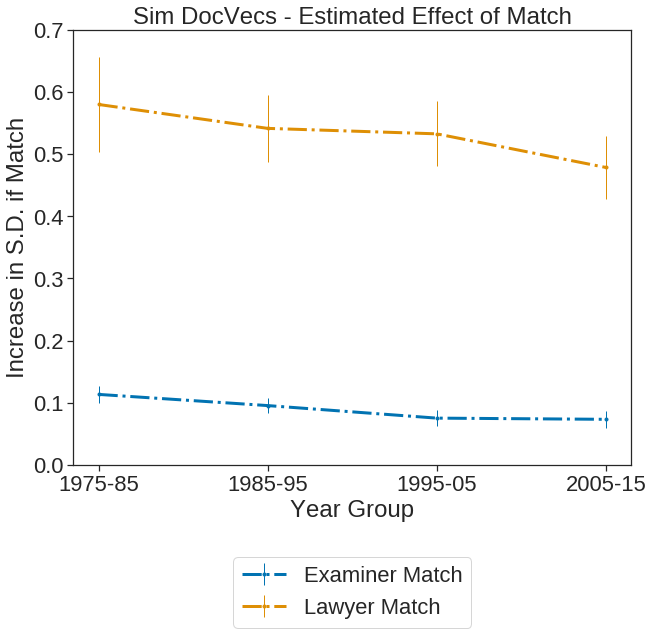

In [14]:
sdv3 = [

    "(('docvecs', 'primclass'), norm_sim_docvecs, N Lawyer M)",

    "(('docvecs', 'primclass'), norm_sim_docvecs, N Examiner M)",

#     "(('docvecs', 'naics_name'), norm_sim_docvecs, N PC M-Sim PC)"
]

get_LE_plots(sdv3, "Sim DocVecs", "DV_LE_primclass", 0.7)

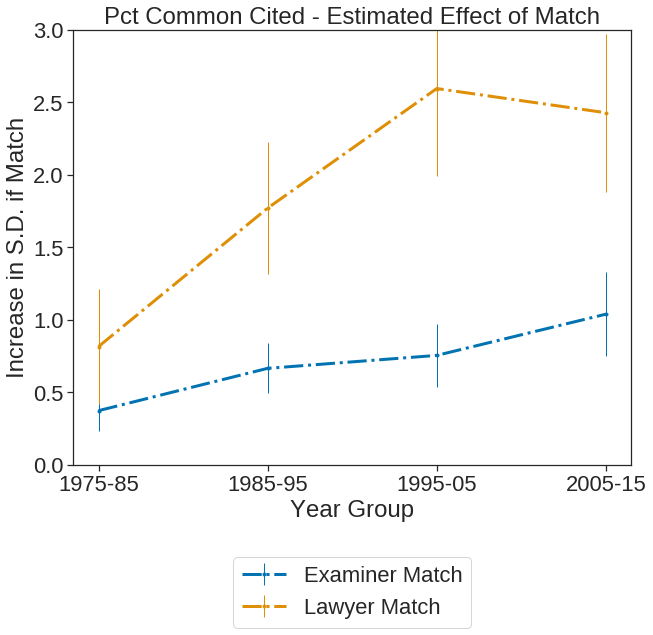

In [186]:
pcc1 = [

    "(('tp_pct_common_cited', 'naics_name'), norm_tp_pct_common_cited, N Lawyer M)",

    "(('tp_pct_common_cited', 'naics_name'), norm_tp_pct_common_cited, N Examiner M)",

#     "(('tp_pct_common_cited', 'naics_name'), norm_tp_pct_common_cited, N PC M-Sim PC)"  
]

get_LE_plots(pcc1, "Pct Common Cited", "pcc_LE", 3)

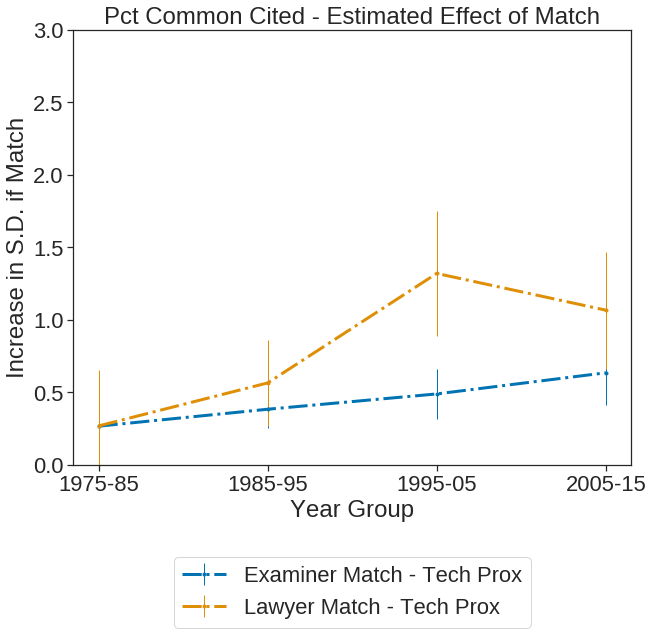

In [187]:
pcc2 = [

#     "(('tp_pct_common_cited', 'naics_name'), norm_tp_pct_common_cited, N Lawyer M)",

#     "(('tp_pct_common_cited', 'naics_name'), norm_tp_pct_common_cited, N Examiner M)",

    "(('tp_pct_common_cited', 'naics_name'), norm_tp_pct_common_cited, N PC M-Sim PC)"  
]

get_LE_plots(pcc2, "Pct Common Cited", "pcc_LE_tp", 3)

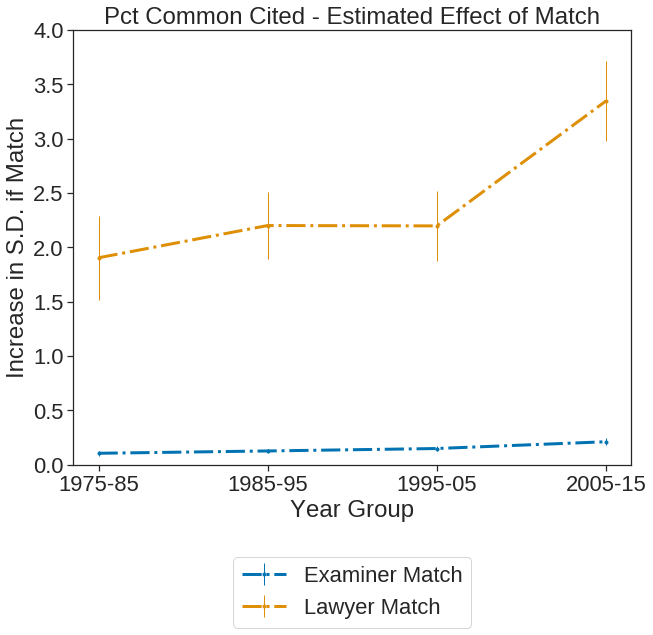

In [15]:
pcc3 = [

    "(('tp_pct_common_cited', 'primclass'), norm_tp_pct_common_cited, N Lawyer M)",

    "(('tp_pct_common_cited', 'primclass'), norm_tp_pct_common_cited, N Examiner M)",

#     "(('tp_pct_common_cited', 'naics_name'), norm_tp_pct_common_cited, N PC M-Sim PC)"  
]

get_LE_plots(pcc3, "Pct Common Cited", "pcc_LE_primclass", 4)